
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy/v0.12?urlpath=lab/tree/first_steps.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[first_steps.ipynb](../_static/notebooks/first_steps.ipynb) |
[first_steps.py](../_static/notebooks/first_steps.py)
</div>


# Getting started with Gammapy

## Introduction

This is a getting started tutorial for [Gammapy](https://docs.gammapy.org/).

In this tutorial we will use the [Second Fermi-LAT Catalog of High-Energy Sources (3FHL) catalog](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/3FHL/), corresponding event list and images to learn how to work with some of the central Gammapy data structures.

We will cover the following topics:

* **Sky maps**
  * We will learn how to handle image based data with gammapy using a Fermi-LAT 3FHL example image. We will work with the following classes:
    - [gammapy.maps.WcsNDMap](../api/gammapy.maps.WcsNDMap.rst)
    - [astropy.coordinates.SkyCoord](http://astropy.readthedocs.io/en/latest/coordinates/index.html)
    - [numpy.ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html)

* **Event lists**
  * We will learn how to handle event lists with Gammapy. Important for this are the following classes: 
    - [gammapy.data.EventList](../api/gammapy.data.EventList.rst)
    - [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table)

* **Source catalogs**
  * We will show how to load source catalogs with Gammapy and explore the data using the following classes:
    - [gammapy.catalog.SourceCatalog](../api/gammapy.catalog.SourceCatalog.rst), specifically [gammapy.catalog.SourceCatalog3FHL](../api/gammapy.catalog.SourceCatalog3FHL.rst)
    - [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table)

* **Spectral models and flux points**
  * We will pick an example source and show how to plot its spectral model and flux points. For this we will use the following classes:
    - [gammapy.spectrum.SpectralModel](../api/gammapy.spectrum.models.SpectralModel.rst), specifically the [PowerLaw2](../api/gammapy.spectrum.models.PowerLaw2.rst) model.
    - [gammapy.spectrum.FluxPoints](../api/gammapy.spectrum.FluxPoints.rst#gammapy.spectrum.FluxPoints)
    - [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table)


## Setup

**Important**: to run this tutorial the environment variable `GAMMAPY_DATA` must be defined and point to the directory on your machine where the datasets needed are placed. To check whether your setup is correct you can execute the following cell:



In [1]:
import os

path = os.path.expandvars("$GAMMAPY_DATA")

if not os.path.exists(path):
    raise Exception("gammapy-data repository not found!")
else:
    print("Great your setup is correct!")

Great your setup is correct!


In case you encounter an error, you can un-comment and execute the following cell to continue. But we recommend to set up your enviroment correctly as decribed [here](../getting-started.rst#download-tutorials) after you are done with this notebook.

In [2]:
# os.environ['GAMMAPY_DATA'] = os.path.join(os.getcwd(), '..')

Now we can continue with the usual IPython notebooks and Python imports:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

## Maps

The [gammapy.maps](https://docs.gammapy.org/dev/maps) package contains classes to work with sky images and cubes.

In this section, we will use a simple 2D sky image and will learn how to:

* Read sky images from FITS files
* Smooth images
* Plot images
* Cutout parts from images
* Reproject images to different WCS

In [5]:
from gammapy.maps import Map

gc_3fhl = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts.fits.gz")

The image is a ``WCSNDMap`` object:

In [6]:
gc_3fhl

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (400, 200)
	ndim  : 2
	unit  : '' 
	dtype : >i8 

The shape of the image is 400 x 200 pixel and it is defined using a cartesian projection in galactic coordinates.

The ``geom`` attribute is a ``WcsGeom`` object:

In [7]:
gc_3fhl.geom

WcsGeom

	axes       : lon, lat
	shape      : (400, 200)
	ndim       : 2
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 20.0 deg x 10.0 deg

Let's take a closer look a the `.data` attribute:

In [8]:
gc_3fhl.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

That looks familiar! It just an *ordinary* 2 dimensional numpy array,  which means you can apply any known numpy method to it:

In [9]:
print("Total number of counts in the image: {:.0f}".format(gc_3fhl.data.sum()))

Total number of counts in the image: 32684


To show the image on the screen we can use the ``plot`` method. It basically calls [plt.imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow), passing the `gc_3fhl.data` attribute but in addition handles axis with world coordinates using [wcsaxes](https://wcsaxes.readthedocs.io/en/latest/) and defines some defaults for nicer plots (e.g. the colormap 'afmhot'):

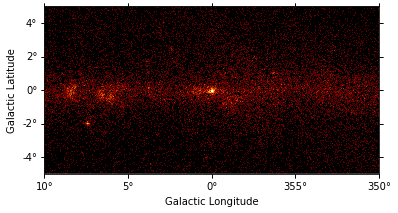

In [10]:
gc_3fhl.plot(stretch="sqrt");

To make the structures in the image more visible we will smooth the data using a Gausian kernel with a radius of 0.5 deg. Again `smooth()` is a wrapper around existing functionality from the scientific Python libraries. In this case it is Scipy's [gaussian_filter](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.gaussian_filter.html) method. For convenience the kernel shape can be specified with as string and the smoothing radius with a quantity. It returns again a map object, that we can plot directly the same way we did above:

In [11]:
gc_3fhl_smoothed = gc_3fhl.smooth(kernel="gauss", width=0.2 * u.deg)

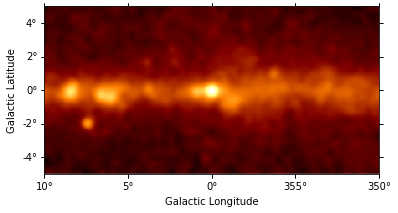

In [12]:
gc_3fhl_smoothed.plot(stretch="sqrt");

The smoothed plot already looks much nicer, but still the image is rather large. As we are mostly interested in the inner part of the image, we will cut out a quadratic region of the size 9 deg x 9 deg around Vela. Therefore we use ``Map.cutout`` to make a cutout map:

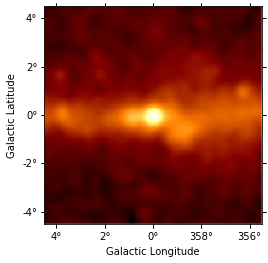

In [13]:
# define center and size of the cutout region
center = SkyCoord(0, 0, unit="deg", frame="galactic")
gc_3fhl_cutout = gc_3fhl_smoothed.cutout(center, 9 * u.deg)
gc_3fhl_cutout.plot(stretch="sqrt");

For a more detailed introdcution to `ganmmapy.maps`, take a look a the [intro_maps.ipynb](intro_maps.ipynb) notebook.

### Exercises

* Add a marker and circle at the position of `Sag A*` (you can find examples in the WCSAxes [documentation](https://wcsaxes.readthedocs.io/en/latest/overlays.html)).

## Event lists

Almost any high-level gamma-ray data analysis starts with the raw measured counts data, which is stored in event lists. In Gammapy event lists are represented by the [gammapy.data.EventList](../api/gammapy.data.EventList.rst) class. 

In this section we will learn how to:

* Read event lists from FITS files
* Access and work with the `EventList` attributes such as `.table` and `.energy` 
* Filter events lists using convenience methods

Let's start with the import from the [gammapy.data](../data/index.rst) submodule:

In [14]:
from gammapy.data import EventList

Very similar to the sky map class an event list can be created, by passing a filename to the `.read()` method:

In [15]:
events_3fhl = EventList.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-events.fits.gz"
)

This time the actual data is stored as an [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table) object. It can be accessed with `.table` attribute: 

In [16]:
events_3fhl.table

<Table length=32843>
  ENERGY      RA       DEC         L      ... DIFRSP1 DIFRSP2 DIFRSP3 DIFRSP4
   MeV       deg       deg        deg     ...                                
 float32   float32   float32    float32   ... float32 float32 float32 float32
--------- --------- ---------- ---------- ... ------- ------- ------- -------
12186.642 260.45935 -33.553337  353.36273 ...     0.0     0.0     0.0     0.0
25496.598 261.37506 -34.395004  353.09607 ...     0.0     0.0     0.0     0.0
15621.498 259.56973 -33.409416  353.05673 ...     0.0     0.0     0.0     0.0
 12816.32 273.95883 -25.340391    6.45856 ...     0.0     0.0     0.0     0.0
18988.387  260.8568 -36.355804  351.23734 ...     0.0     0.0     0.0     0.0
 11610.23 266.15518 -26.224436  2.1986027 ...     0.0     0.0     0.0     0.0
13960.802 271.44742 -29.615316  1.6267247 ...     0.0     0.0     0.0     0.0
10477.372  266.3981  -28.96814  359.97003 ...     0.0     0.0     0.0     0.0
 13030.88 271.70428 -20.632627    9.59348 ...     0.0     0.0     0.0     0.0
      ...       ...        ...        ... ...     ...     ...     ...     ...
387834.72  270.3779  -21.56711   8.171749 ...     0.0     0.0     0.0     0.0
 20559.74  268.5538 -26.345692   3.200638 ...     0.0     0.0     0.0     0.0
27209.146 266.59344  -30.52607  358.72775 ...     0.0     0.0     0.0     0.0
13911.061 269.30997 -27.239439  2.7684028 ...     0.0     0.0     0.0     0.0
13226.425 265.16287 -27.344238  0.7796942 ...     0.0     0.0     0.0     0.0
17445.463 266.63342 -28.807201 0.21464892 ...     0.0     0.0     0.0     0.0
13133.864 270.42474 -22.651058   7.251185 ...     0.0     0.0     0.0     0.0
32095.705  266.0002  -29.77206   359.1034 ...     0.0     0.0     0.0     0.0
18465.783 266.39728 -29.105953  359.85202 ...     0.0     0.0     0.0     0.0
 14457.25 262.72217 -34.388405   353.7184 ...     0.0     0.0     0.0     0.0

You can do *len* over event_3fhl.table to find the total number of events.

In [17]:
print("Total number of events: {}".format(len(events_3fhl.table)))

Total number of events: 32843


And we can access any other attribute of the `Table` object as well:

In [18]:
events_3fhl.table.colnames

['ENERGY',
 'RA',
 'DEC',
 'L',
 'B',
 'THETA',
 'PHI',
 'ZENITH_ANGLE',
 'EARTH_AZIMUTH_ANGLE',
 'TIME',
 'EVENT_ID',
 'RUN_ID',
 'RECON_VERSION',
 'CALIB_VERSION',
 'EVENT_CLASS',
 'EVENT_TYPE',
 'CONVERSION_TYPE',
 'LIVETIME',
 'DIFRSP0',
 'DIFRSP1',
 'DIFRSP2',
 'DIFRSP3',
 'DIFRSP4']

For convenience we can access the most important event parameters as properties on the `EventList` objects. The attributes will return corresponding Astropy objects to represent the data, such as [astropy.units.Quantity](http://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity), [astropy.coordinates.SkyCoord](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) or [astropy.time.Time](http://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time) objects:

In [19]:
events_3fhl.energy.to("GeV")

<Quantity [12.186643, 25.4966  , 15.621499, ..., 32.095707, 18.465784,
           14.457251] GeV>

In [20]:
events_3fhl.galactic
# events_3fhl.radec

<SkyCoord (Galactic): (l, b) in deg
    [(353.36228879,  1.75408483), (353.09562941,  0.6522806 ),
     (353.05628243,  2.44528685), ..., (359.10295505, -0.1359316 ),
     (359.85157506, -0.08269984), (353.71795506, -0.26883694)]>

In [21]:
events_3fhl.time

<Time object: scale='tt' format='mjd' value=[54682.82946153 54682.89243456 54682.89709472 ... 57236.75267735
 57233.37455141 57233.44802852]>

In addition `EventList` provides convenience methods to filter the event lists. One possible use case is to find the highest energy event within a radius of 0.5 deg around the vela position:

In [22]:
# select all events within a radius of 0.5 deg around center
events_gc_3fhl = events_3fhl.select_sky_cone(center=center, radius=0.5 * u.deg)

# sort events by energy
events_gc_3fhl.table.sort("ENERGY")

# and show highest energy photon
events_gc_3fhl.energy[-1].to("GeV")

<Quantity 1917.85925 GeV>

### Exercises

* Make a counts energy spectrum for the galactic center region, within a radius of 10 deg.

## Source catalogs

Gammapy provides a convenient interface to access and work with catalog based data. 

In this section we will learn how to:

* Load builtins catalogs from [gammapy.catalog](../catalog/index.rst)
* Sort and index the underlying Astropy tables
* Access data from individual sources

Let's start with importing the 3FHL catalog object from the [gammapy.catalog](../catalog/index.rst) submodule:

In [23]:
from gammapy.catalog import SourceCatalog3FHL

First we initialize the Fermi-LAT 3FHL catalog and directly take a look at the `.table` attribute:

In [24]:
fermi_3fhl = SourceCatalog3FHL()
fermi_3fhl.table

<Table masked=True length=1556>
   Source_Name     RAJ2000  DEJ2000  ... Redshift     NuPeak_obs    
                     deg      deg    ...                  Hz        
     bytes18       float32  float32  ... float32       float32      
------------------ -------- -------- ... -------- ------------------
3FHL J0001.2-0748    0.3107  -7.8075 ...      nan  306196370000000.0
3FHL J0001.9-4155    0.4849 -41.9303 ...      nan 6309576500000000.0
3FHL J0002.1-6728    0.5283 -67.4825 ...      nan 4466832000000000.0
3FHL J0003.3-5248    0.8300 -52.8150 ...      nan       7.079464e+16
3FHL J0007.0+7303    1.7647  73.0560 ...      nan                nan
3FHL J0007.9+4711    1.9931  47.1920 ...   0.2800 2511884200000000.0
3FHL J0008.4-2339    2.1243 -23.6514 ...   0.1470  524807800000000.0
3FHL J0009.1+0628    2.2874   6.4814 ...      nan  663742400000000.0
3FHL J0009.4+5030    2.3504  50.5049 ...      nan 1412536400000000.0
               ...      ...      ... ...      ...                ...
3FHL J2347.9-1630  356.9978 -16.5106 ...   0.5760    9332549000000.0
3FHL J2350.5-3006  357.6354 -30.1070 ...   0.2237 3981075200000000.0
3FHL J2351.5-7559  357.8926 -75.9890 ...      nan                nan
3FHL J2352.1+1753  358.0415  17.8865 ...      nan 1737799900000000.0
3FHL J2356.2+4035  359.0746  40.5985 ...   0.1310 6309576500000000.0
3FHL J2357.4-1717  359.3690 -17.2996 ...      nan       8.912525e+16
3FHL J2358.4-1808  359.6205 -18.1408 ...      nan                nan
3FHL J2358.5+3829  359.6266  38.4963 ...      nan                nan
3FHL J2359.1-3038  359.7760 -30.6397 ...   0.1650       2.818388e+17
3FHL J2359.3-2049  359.8293 -20.8256 ...   0.0960 4073799600000000.0

This looks very familiar again. The data is just stored as an [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table) object. We have all the methods and attributes of the `Table` object available. E.g. we can sort the underlying table by `Signif_Avg` to find the top 5 most significant sources:



In [25]:
# sort table by significance
fermi_3fhl.table.sort("Signif_Avg")

# invert the order to find the highest values and take the top 5
top_five_TS_3fhl = fermi_3fhl.table[::-1][:5]

# print the top five significant sources with association and source class
top_five_TS_3fhl[["Source_Name", "ASSOC1", "ASSOC2", "CLASS", "Signif_Avg"]]

<Table masked=True length=5>
   Source_Name               ASSOC1           ...  CLASS  Signif_Avg
     bytes18                bytes26           ...  bytes7  float32  
------------------ -------------------------- ... ------- ----------
3FHL J0534.5+2201  Crab Nebula                ... PWN        168.641
3FHL J1104.4+3812  Mkn 421                    ... BLL        144.406
3FHL J0835.3-4510  PSR J0835-4510             ... PSR        138.801
3FHL J0633.9+1746  PSR J0633+1746             ... PSR         99.734
3FHL J1555.7+1111  PG 1553+113                ... BLL         94.411

If you are interested in the data of an individual source you can access the information from catalog using the name of the source or any alias source name that is defined in the catalog:

In [26]:
mkn_421_3fhl = fermi_3fhl["3FHL J1104.4+3812"]

# or use any alias source name that is defined in the catalog
mkn_421_3fhl = fermi_3fhl["Mkn 421"]
print(mkn_421_3fhl.data["Signif_Avg"])

144.40611


### Exercises

* Try to load the Fermi-LAT 2FHL catalog and check the total number of sources it contains.
* Select all the sources from the 2FHL catalog which are contained in the Galactic Center region. The methods [`WcsGeom.contains()`](https://docs.gammapy.org/stable/api/gammapy.maps.WcsGeom.html#gammapy.maps.WcsGeom.contains) and [`SourceCatalog.positions`](https://docs.gammapy.org/stable/api/gammapy.catalog.SourceCatalog.html#gammapy.catalog.SourceCatalog.positions) might be helpful for this. Add markers for all these sources and try to add labels with the source names. The function [ax.text()](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.text.html#matplotlib.axes.Axes.text) might be also helpful.
* Try to find the source class of the object at position ra=68.6803, dec=9.3331
 

## Spectral models and flux points

In the previous section we learned how access basic data from individual sources in the catalog. Now we will go one step further and explore the full spectral information of sources. We will learn how to:

* Plot spectral models
* Compute integral and energy fluxes
* Read and plot flux points

As a first example we will start with the Crab Nebula:

In [27]:
crab_3fhl = fermi_3fhl["Crab Nebula"]
print(crab_3fhl.spectral_model)

PowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.220e+00 2.498e-02                nan nan  False
	amplitude 1.713e-10 3.389e-12 cm-2 GeV-1 s-1 nan nan  False
	reference 2.273e+01 0.000e+00            GeV nan nan   True

Covariance: 

	   name     index   amplitude reference
	--------- --------- --------- ---------
	    index 6.241e-04 0.000e+00 0.000e+00
	amplitude 0.000e+00 1.148e-23 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00


The `crab_3fhl.spectral_model` is an instance of the [gammapy.spectrum.models.PowerLaw2](../api/gammapy.spectrum.models.PowerLaw2.rst#gammapy.spectrum.models.PowerLaw2) model, with the parameter values and errors taken from the 3FHL catalog. 

Let's plot the spectral model in the energy range between 10 GeV and 2000 GeV:

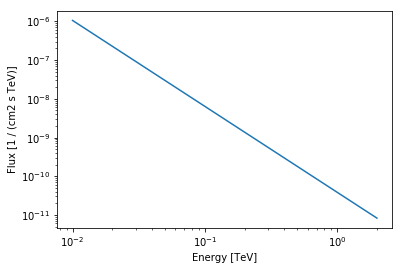

In [28]:
ax_crab_3fhl = crab_3fhl.spectral_model.plot(
    energy_range=[10, 2000] * u.GeV, energy_power=0
)

We assign the return axes object to variable called `ax_crab_3fhl`, because we will re-use it later to plot the flux points on top.

To compute the differential flux at 100 GeV we can simply call the model like normal Python function and convert to the desired units:

In [29]:
crab_3fhl.spectral_model(100 * u.GeV).to("cm-2 s-1 GeV-1")

<Quantity 6.38489128e-12 1 / (cm2 GeV s)>

Next we can compute the integral flux of the Crab between 10 GeV and 2000 GeV:

In [30]:
crab_3fhl.spectral_model.integral(emin=10 * u.GeV, emax=2000 * u.GeV).to(
    "cm-2 s-1"
)

<Quantity 8.67457342e-09 1 / (cm2 s)>

We can easily convince ourself, that it corresponds to the value given in the Fermi-LAT 3FHL catalog:

In [31]:
crab_3fhl.data["Flux"]

<Quantity 8.658909e-09 1 / (cm2 s)>

In addition we can compute the energy flux between 10 GeV and 2000 GeV:

In [32]:
crab_3fhl.spectral_model.energy_flux(emin=10 * u.GeV, emax=2000 * u.GeV).to(
    "erg cm-2 s-1"
)

<Quantity 5.31148913e-10 erg / (cm2 s)>

Next we will access the flux points data of the Crab:

In [33]:
print(crab_3fhl.flux_points)

FluxPoints(sed_type="flux", n_points=5)


If you want to learn more about the different flux point formats you can read the specification [here](http://gamma-astro-data-formats.readthedocs.io/en/latest/results/flux_points/index.html#flux-points).

No we can check again the underlying astropy data structure by accessing the `.table` attribute:

In [34]:
crab_3fhl.flux_points.table

<Table length=5>
      e_ref         e_min   e_max  ...   flux_ul     e2dnde_ul    sqrt_ts 
       GeV           GeV     GeV   ... 1 / (cm2 s) erg / (cm2 s)          
     float64       float64 float64 ...   float64      float64     float32 
------------------ ------- ------- ... ----------- ------------- ---------
14.142135623730951    10.0    20.0 ...         nan           nan 125.15745
31.622776601683793    20.0    50.0 ...         nan           nan  88.71535
 86.60254037844386    50.0   150.0 ...         nan           nan 59.087498
 273.8612787525831   150.0   500.0 ...         nan           nan 33.076164
            1000.0   500.0  2000.0 ...         nan           nan 15.573053

Finally let's combine spectral model and flux points in a single plot and scale with `energy_power=2` to obtain the spectral energy distribution:

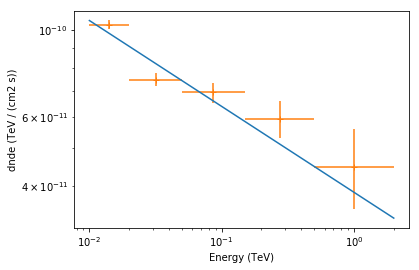

In [35]:
ax = crab_3fhl.spectral_model.plot(
    energy_range=[10, 2000] * u.GeV, energy_power=2
)
crab_3fhl.flux_points.to_sed_type("dnde").plot(ax=ax, energy_power=2);

### Exercises

* Plot the spectral model and flux points for PKS 2155-304 for the 3FGL and 2FHL catalogs. Try to plot the error of the model (aka "Butterfly") as well. Note this requires the [uncertainties package](https://pythonhosted.org/uncertainties/) to be installed on your machine.


## What next?

This was a quick introduction to some of the high-level classes in Astropy and Gammapy.

* To learn more about those classes, go to the API docs (links are in the introduction at the top).
* To learn more about other parts of Gammapy (e.g. Fermi-LAT and TeV data analysis), check out the other tutorial notebooks.
* To see what's available in Gammapy, browse the [Gammapy docs](https://docs.gammapy.org/) or use the full-text search.
* If you have any questions, ask on the mailing list.